# Week 8 - Praktikum 8 - Web Data Acquisition

Raden Bagus Rifa'i Kacanegara - 162112133047

Algoritma Pemrograman II SD-A1

## 1. Scraping website UNAIR News

In [1]:
# Import Libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm as tqdm_progress

Disini, kita meng-import library atau package yang dibutuhkan, yaitu requests, BeautifulSoup, dan pandas.

In [2]:
# Deklarasi fungsi crawling
def crawl_and_scrape_unair_1news(url):
  response = requests.get(url) # Melakukan requests ke website tujuan
  if response.status_code == 200: # Apabila berhasil konek, maka akan melakukan:
    # Parsing HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    # Mencari judul yang ada di class elementor-heading-title elementor-size-default dengan tag h2
    judul_elem = soup.find('h2', class_='elementor-heading-title elementor-size-default')
    judul_berita = judul_elem.text.strip()
  return judul_berita

Kode di atas digunakan untuk melakukan scraping ke website UNAIR News. Data yang ingin diambil adalah judul dari suatu berita, maka kita dapat mengambil judul berita yang memliki tag `<h2>` dan class `elementor-heading-title elementor-size-default`.


In [3]:
url_berita = 'https://unair.ac.id/unair-raih-45-trees-rating-pada-ui-greenmetric-world-university-ranking/'
print(crawl_and_scrape_unair_1news(url_berita)) # Inisiasi fungsi scraping

UNAIR Raih 4,5 Trees Rating pada UI GreenMetric World University Ranking


Setelah kita menjalankan fungsi dengan parameter URL berita, kita dapat melihat hasil yang didapatkan yaitu artikel dengan judul "UNAIR Raih 4,5 Trees Rating pada UI GreenMetric World University Ranking".

## 2. Crawling UNAIR News untuk judul berita di kategori featured news

In [4]:
def crawl_and_scrape_unair_news(base_url, num_pages):
    judul_berita = []

    for page in tqdm_progress(range(1, num_pages + 1), desc="Scraping Pages"):
        url = f"{base_url}/page/{page}/"
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            post_judul_berita = soup.find_all('h3', class_='elementor-post__title')

            for judul in post_judul_berita:
                link = judul.find('a')
                judul_text = link.text.strip() if link else "Tidak ada judul"
                judul_berita.append(judul_text)

    return judul_berita

Kode di atas digunakan untuk melakukan crawling ke website UNAIR News. Data yang ingin diambil adalah judul dari beberapa berita yang ada di kategori berita. Perbedaannya dari kode sebelumnya adalah kita melakukan `soup.find_all` dan `for loop` untuk setiap halaman yang diinputkan agar mendapatkan seluruh judul di halaman tersebut yang memiliki class `elementor-post__title` dan tag `<h3>`.

In [5]:
url = "https://unair.ac.id/category/berita"
byk_halaman = 5
titles = crawl_and_scrape_unair_news(url, byk_halaman)

Scraping Pages: 100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


In [6]:
df_unair_news = pd.DataFrame(titles, columns=['title'])
df_unair_news.head()

,title
0,Websvaganza 2023 Hadirkan Bazar Kosmetik untuk...
1,Mahasiswa UNAIR Sabet Juara 1 Kategori Lomba I...
2,Pentingnya Mengenal Potensi Diri Melalui Pemah...
3,Dukung Pendidikan Merata UNAIR Berikan Beasisw...
4,Apa Sih UKM Wanala ?


In [7]:
df_unair_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   60 non-null     object
dtypes: object(1)
memory usage: 608.0+ bytes


Setelah fungsi crawling di atas dijalankan, kita mendapatkan judul berita dari 5 halaman kategori berita sebanyak 60 buah yang disimpan di variabel `df_unair_news`.

## 3. Crawling dengan *Scrapy*

In [8]:
!pip install scrapy

In [9]:
import scrapy

Disini, kita install dan import package `scrapy` yaitu library yang akan kita gunakan untuk melakukan scraping.



In [10]:
!scrapy startproject playstation_store
!cd playstation_store/playstation_store/spiders && scrapy genspider playstation_spider store.playstation.com

Error: scrapy.cfg already exists in /content/playstation_store
/content/playstation_store/playstation_store/spiders/playstation_spider.py already exists


Pada kode di atas, kita membuat project scrapy yang memiliki nama `playstation_store`. Kemudian, kita membuat file Spider dengan nama `playstation_spider` yang akan melakukan koneksi ke `store.playstation.com`.

In [11]:
%%writefile /content/playstation_store/playstation_store/spiders/playstation_spider.py
import scrapy
import pandas as pd

class PlaystationSpider(scrapy.Spider):
    name = 'scrape_ps'
    base_url = 'https://store.playstation.com/en-id/category/05a2d027-cedc-4ac0-abeb-8fc26fec7180/'

    def start_requests(self):
        num_pages = 5  # Crawling 5 halaman
        for page in range(1, num_pages + 1):
            url = f'{self.base_url}{page}/'
            yield scrapy.Request(url, callback=self.parse)

    def parse(self, response):
        titles = response.css('span.psw-t-body.psw-c-t-1.psw-t-truncate-2.psw-m-b-2::text').getall()
        prices = response.css('span.psw-m-r-3::text').getall()

        for title, price in zip(titles, prices):
            yield {
                'title': title.strip(),
                'price': price.strip()
                }

Overwriting /content/playstation_store/playstation_store/spiders/playstation_spider.py


Pada kode di atas, kita melakukan *overwrite* dari file `playstation_spider.py` yang berisikan fungsi untuk melakukan crawling. Fungsi crawling yang dijalankan bernama `scrape_ps`. Sumber data adalah dari url `https://store.playstation.com/en-id/category/05a2d027-cedc-4ac0-abeb-8fc26fec7180/[nomor halaman]` dimana kita akan mengambil contoh crawling sebanyak 5 halaman. Data yang diambil adalah setiap judul game yang terletak di

class: `span.psw-t-body.psw-c-t-1.psw-t-truncate-2.psw-m-b-2`

dan harga yang terletak pada

class: `span.psw-m-r-3`.

In [12]:
!cd playstation_store && scrapy crawl scrape_ps -o output_scrape.csv -t csv

/usr/local/lib/python3.10/dist-packages/scrapy/commands/__init__.py:171: ScrapyDeprecationWarning: The -t/--output-format command line option is deprecated in favor of specifying the output format within the output URI using the -o/--output or the -O/--overwrite-output option (i.e. -o/-O <URI>:<FORMAT>). See the documentation of the -o or -O option or the following examples for more information. Examples working in the tutorial: scrapy crawl quotes -o quotes.csv:csv   or   scrapy crawl quotes -O quotes.json:json
  feeds = feed_process_params_from_cli(
2023-11-05 06:47:46 [scrapy.utils.log] INFO: Scrapy 2.11.0 started (bot: playstation_store)
2023-11-05 06:47:46 [scrapy.utils.log] INFO: Versions: lxml 4.9.3.0, libxml2 2.10.3, cssselect 1.2.0, parsel 1.8.1, w3lib 2.1.2, Twisted 22.10.0, Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0], pyOpenSSL 23.2.0 (OpenSSL 3.1.4 24 Oct 2023), cryptography 41.0.5, Platform Linux-5.15.120+-x86_64-with-glibc2.35
2023-11-05 06:47:46 [scrapy.add

Pada kode di atas, kita menjalankan scraping dengan sintaks `scrapy crawl scrape_ps` dan akan menghasilkan output berupa `output_scrape.csv`.

In [13]:
# Hasil scrape
df_scrape_ps = pd.read_csv("/content/playstation_store/output_scrape.csv")
df_scrape_ps

,title,price
0,"Rogue Legacy 2 (Simplified Chinese, English, K...","Rp 349,000"
1,"Inscryption (Simplified Chinese, English, Kore...","Rp 279,000"
2,Deus Ex: Mankind Divided (Game),"Rp 102,000"
3,"Killing Floor 2 (Simplified Chinese, English, ...","Rp 429,000"
4,Lonely Mountains: Downhill (Simplified Chinese...,"Rp 279,000"
...,...,...
140,The Dark Pictures Anthology: Little Hope PS4 &...,"Rp 119,600"
141,The Dark Pictures Anthology: Little Hope PS4 &...,"Rp 119,600"
142,ODDWORLD: NEW 'N' TASTY full game (English Ver.),"Rp 364,000"
143,What Remains of Edith Finch (Simplified Chines...,"Rp 69,750"


## 4. Simpan file ke Repo Github

Untuk menyimpan file hasil scrape ke GitHub, kita perlu mengekspor setiap df ke csv, kemudian kita download dan lakukan commit ke GitHub.

In [14]:
df_unair_news.to_csv('scrape_unairnews.csv', index=False)
df_scrape_ps.to_csv('scrape_ps.csv', index=False)

Lalu, kita download file csv tersebut, dan kita upload ke GitHub sebagai berikut:

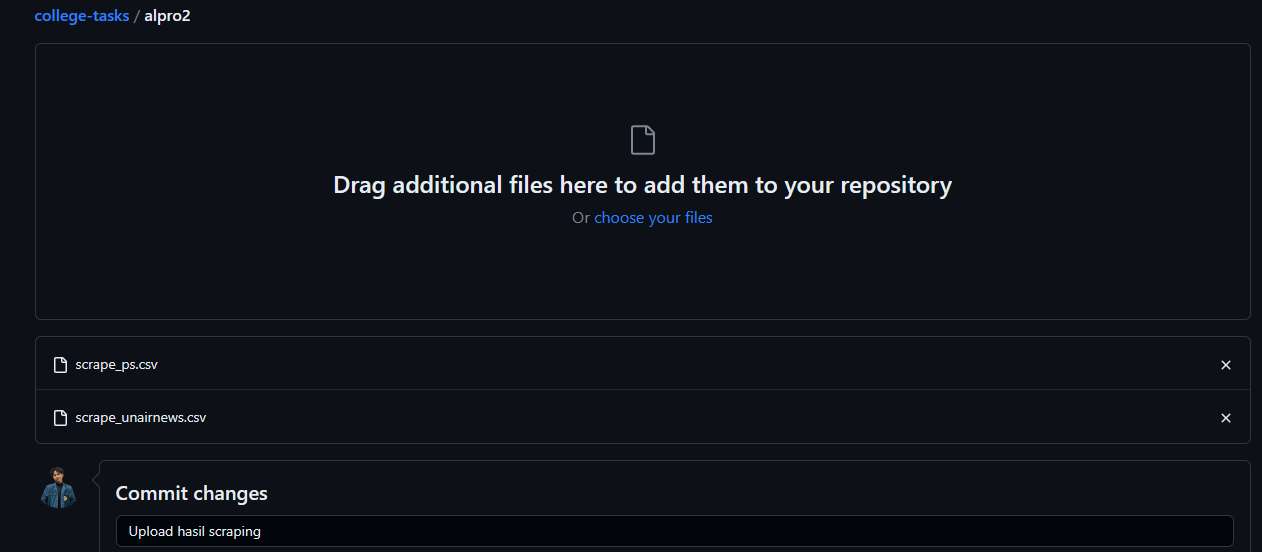

File berhasil di upload pada https://github.com/RifaiKN/college-tasks/tree/main/alpro2

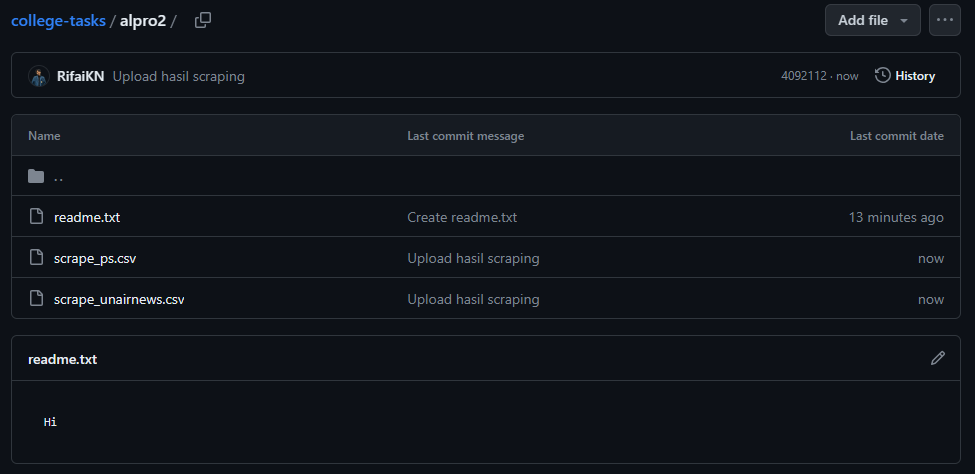